In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Light curves

In [2]:
light_on = pd.read_csv('SebAndreLightOn.txt', sep='\t')
light_off = pd.read_csv('SebAndreLightOff.txt', sep='\t')

First, we plot these distributions raw.

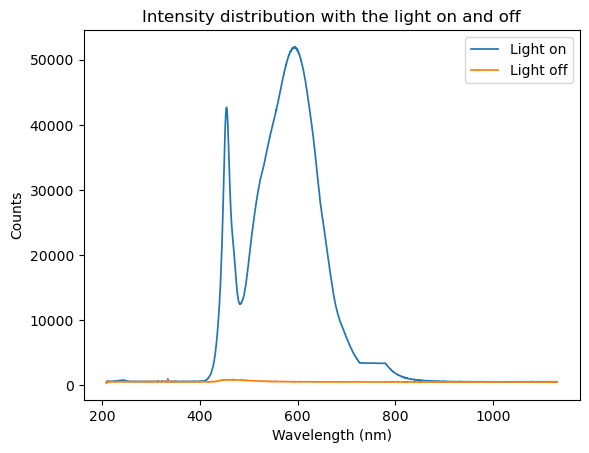

In [3]:
plt.title('Intensity distribution with the light on and off')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')
plt.plot(light_on['#lambda/nm'], light_on['C1'], linewidth=1.25, label='Light on');
plt.plot(light_off['#lambda/nm'], light_off['C1'], linewidth=1.25, label='Light off');
plt.legend();
plt.savefig('lightcurve.pdf')

Now we plot the distribution while subtracting the dark counts.

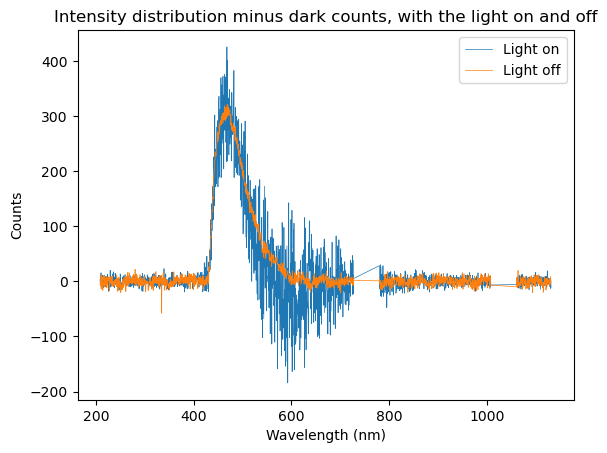

In [4]:
plt.title('Intensity distribution minus dark counts, with the light on and off')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')
plt.plot(light_on['#lambda/nm'], light_on['C1'] - light_on['DC'], linewidth=0.5, label='Light on');
plt.plot(light_off['#lambda/nm'], light_off['C1'] - light_off['DC'], linewidth=0.5, label='Light off');
plt.legend();
plt.savefig('lightcurve_minus_dc.pdf')

# 2. Analysis of simulated data

## 2.1 Cleaning the data

We read the data and perform the cuts:
- Exit position lower than the fiber radius
- No Rayleigh scattering
- No photons that had reflections in both the ClCl and CoCl interfaces

In [5]:
data = pd.read_pickle('SimData.pkl')

In [6]:
data['r_exit'] = np.sqrt(data['# y_exit']**2 + data['z_exit']**2)

In [7]:
data = data[data['r_exit']<=0.125]

In [8]:
data = data[data['rayleighScatterings']==0.0]

In [9]:
mask = (data['reflCoCl']>0) & (data['reflClCl']>0)

In [10]:
data = data[~mask]

## 2.2 Distribution of $\theta$

The angle is calculated and the dataset is divided into core and cladding photons.

In [11]:
data['theta'] = np.arccos(data['px_start'])*180/np.pi

In [12]:
core = data[data['reflCoCl']>0]
clad = data[data['reflClCl']>0]

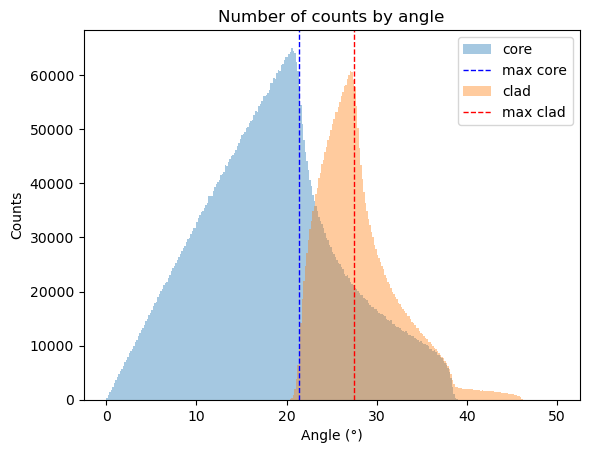

In [13]:
plt.xlabel('Angle (°)')
plt.ylabel('Counts')
plt.title('Number of counts by angle')
plt.hist(core['theta'], bins=np.linspace(0,50,301), alpha = 0.4, label='core');
plt.axvline(np.degrees(0.373), color='b', linestyle='dashed', linewidth=1, label='max core'); # 21.37 degrees
plt.hist(clad['theta'], bins=np.linspace(0,50,301), alpha = 0.4, label='clad');
plt.axvline(np.degrees(0.479), color='r', linestyle='dashed', linewidth=1, label='max clad'); # 27.44 degrees
plt.legend();
#plt.savefig('angle.pdf')

## 2.3 $r_\mathrm{min}$ calculation

In [14]:
data['r_min'] = np.abs( data['y_start']*data['pz_start'] - data['z_start']*data['py_start'] ) / np.sqrt( data['py_start']**2 + data['pz_start']**2 )

In [15]:
# divide into core and cladding again

core = data[data['reflCoCl']>0]
clad = data[data['reflClCl']>0]

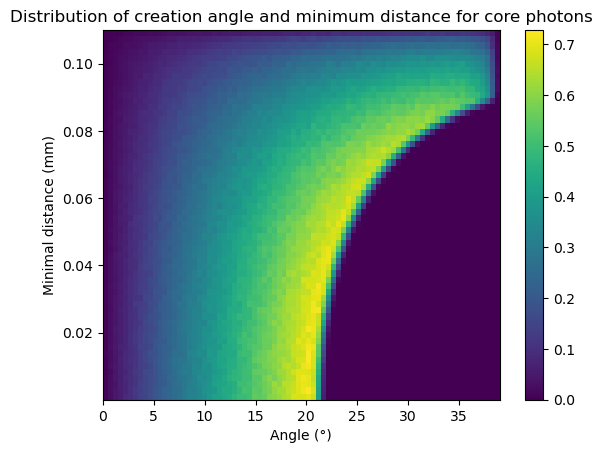

In [16]:
plt.title('Distribution of creation angle and minimum distance for core photons');
plt.xlabel('Angle (°)');
plt.ylabel('Minimal distance (mm)');
plt.hist2d(core['theta'], core['r_min'], bins=[80, 60], density=True);
plt.colorbar();
#plt.savefig('2dhist_core.pdf')

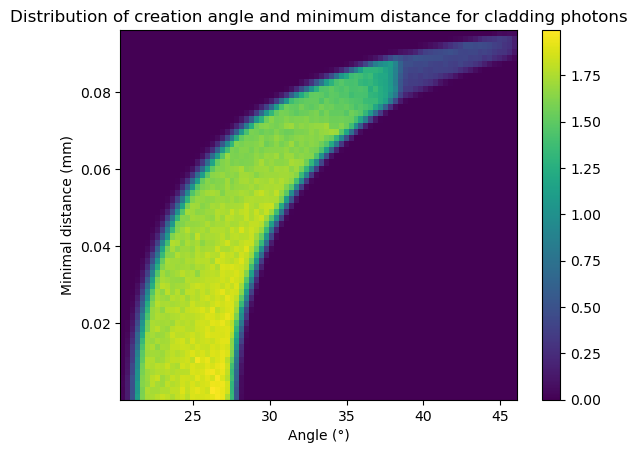

In [17]:
plt.title('Distribution of creation angle and minimum distance for cladding photons');
plt.xlabel('Angle (°)');
plt.ylabel('Minimal distance (mm)');
plt.hist2d(clad['theta'], clad['r_min'], bins=[80, 60], density=True);
plt.colorbar();
#plt.savefig('2dhist_clad.pdf')

## 2.4 Intensity vs creation position

The two following plots are just to get an idea of what distribution to expect.

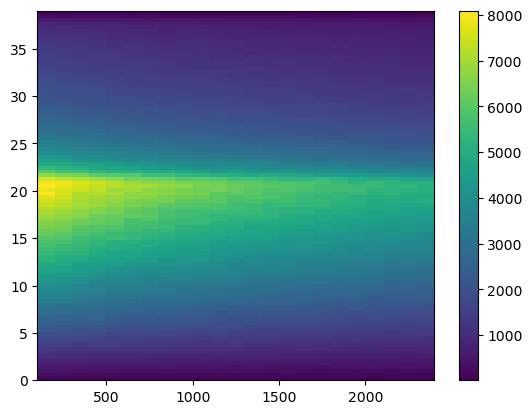

In [18]:
#let's explore
bins=np.linspace(100,2400,24)

plt.hist2d(core['gpsPosX']+1, core['theta'], bins=[bins, 100]);
plt.colorbar();

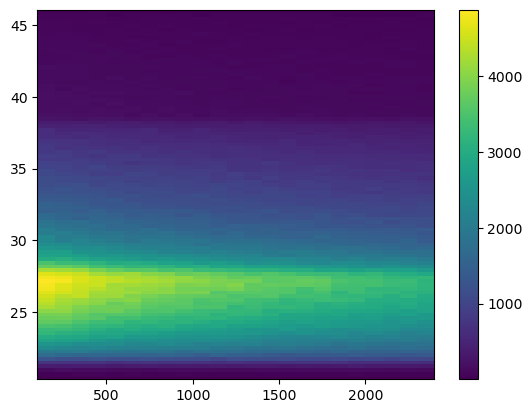

In [19]:
#let's explore
bins=np.linspace(100,2400,24)

plt.hist2d(clad['gpsPosX']+1, clad['theta'], bins=[bins, 100]);
plt.colorbar();

In this part, some choices were made simply to make the code spit out something that makes sense.  

In [20]:
from scipy.optimize import curve_fit

In [21]:
def exp(x, a, k):
        return a*np.exp(-x*k)

def calc_a(plot, core_or_clad=core, initial_angle=20, step=0.5):
    '''
    Calculate and return the a coefficient and optionally save a plot of the fit along with the histogram.
    The option plot must be set to 1 to output and save the plot.
    core_or_clad must be the core or clad DataFrame
    This will take all events in the range of angles [initial_angle, initial_angle + step]
    When saving the figure, this doesn't differentiate between core and clad. You must do that manually.
    '''
    
    bins = np.linspace(100, 2500, 25)
    mask1 = core_or_clad['theta'] > initial_angle
    mask2 = core_or_clad['theta'] < initial_angle+step 
    intensity = core_or_clad[mask1&mask2]
    counts, _ = np.histogram(intensity['gpsPosX'], bins = bins)
    
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)]) #This is the part I think might be wrong.
    popt, _ = curve_fit(exp,  xdata=binscenters, ydata=counts, p0=(counts[0],0.0001))
    a_value = popt[1]
    
    if plot==1:
        xspace = np.linspace(100, 2500, 100000)
        plt.title(f'Intensity as a function of excitation location ({initial_angle}°-{initial_angle+step}°)');
        plt.xlabel('Excitation position (mm)');
        plt.ylabel('Counts');
        plt.hist(intensity['gpsPosX'], label='Intensity', bins=bins, alpha=0.6, color='blue');
        plt.plot(xspace, exp(xspace, *popt), ls='--', color='b', linewidth=2.5, label='Fit with a=%1.5f mm^-1' % a_value);
        plt.legend();
        plt.savefig(f'intensity_fit_{initial_angle}_{initial_angle+step}.pdf');
        plt.show()

    return a_value

The following lines produce the plots but you have to change ```calc_a(0...``` to ```calc_a(1...```.

In [22]:
core_angles = np.linspace(6,30,25)
core_a_values = [calc_a(0,core,i,0.5) for i in core_angles]

clad_angles = np.linspace(23,31,9)
clad_a_values = [calc_a(0,clad,i,0.5) for i in clad_angles]

Finally, the different attenuation parameters are plotted for core and cladding photons.

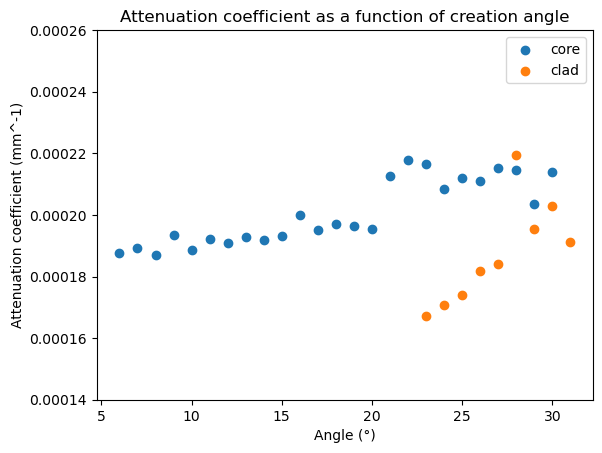

In [25]:
plt.title('Attenuation coefficient as a function of creation angle');
plt.xlabel('Angle (°)');
plt.ylabel('Attenuation coefficient (mm^-1)');
plt.ylim(0.00014,0.00026)
plt.scatter(core_angles, core_a_values, label='core');
plt.scatter(clad_angles, clad_a_values, label='clad');
plt.legend();
#plt.savefig('attenuation.pdf');